# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

> Safety: No unsupported claims. Treat outputs as decision support, not automation.

## Dataset Information
```
Additional Information

A complex modern semi-conductor manufacturing process is normally under consistent surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system. The measured signals contain a combination of useful information, irrelevant information as well as noise. It is often the case that useful information is buried in the latter two. Engineers typically have a much larger number of signals than are actually required. If we consider each type of signal as a feature, then feature selection may be applied to identify the most relevant signals. The Process Engineers may then use these signals to determine key factors contributing to yield excursions downstream in the process. This will enable an increase in process throughput, decreased time to learning and reduce the per unit production costs.

To enhance current business improvement techniques the application of feature selection as an intelligent systems technique is being investigated.

The dataset presented in this case represents a selection of such features where each example represents a single production entity with associated measured features and the labels represent a simple pass/fail yield for in house line testing, figure 2, and associated date time stamp. Where –1 corresponds to a pass and 1 corresponds to a fail and the data time stamp is for that specific test point.


Using feature selection techniques it is desired to rank features according to their impact on the overall yield for the product, causal relationships may also be considered with a view to identifying the key features.

Results may be submitted in terms of feature relevance for predictability using error rates as our evaluation metrics. It is suggested that cross validation be applied to generate these results. Some baseline results are shown below for basic feature selection techniques using a simple kernel ridge classifier and 10 fold cross validation.

Baseline Results: Pre-processing objects were applied to the dataset simply to standardize the data and remove the constant features and then a number of different feature selection objects selecting 40 highest ranked features were applied with a simple classifier to achieve some initial results. 10 fold cross validation was used and the balanced error rate (*BER) generated as our initial performance metric to help investigate this dataset.


SECOM Dataset: 1567 examples 591 features, 104 fails

FSmethod (40 features) BER % True + % True - %
S2N (signal to noise) 34.5 +-2.6 57.8 +-5.3 73.1 +2.1
Ttest 33.7 +-2.1 59.6 +-4.7 73.0 +-1.8
Relief 40.1 +-2.8 48.3 +-5.9 71.6 +-3.2
Pearson 34.1 +-2.0 57.4 +-4.3 74.4 +-4.9
Ftest 33.5 +-2.2 59.1 +-4.8 73.8 +-1.8
Gram Schmidt 35.6 +-2.4 51.2 +-11.8 77.5 +-2.3

Has Missing Values?

Yes
```

### 1. Setup

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 150,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Root directory
ROOT = Path(os.getcwd()).parent

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = Path(DATA_DIR/"raw")
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missing!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

# Model directory
MODEL_DIR = Path(ROOT/"models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

### 2. Helper functions

In [2]:
# Figure saver helper (use after each plot)
RESULT_DIR_EDA = Path(RESULT_DIR/"EDA")
RESULT_DIR_EDA.mkdir(exist_ok=True, parents=True)
def savefig(name):
    out = RESULT_DIR_EDA/name
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)

In [3]:
def annotate_countplot(ax, summary, label_map={0:"Pass", 1:"Fail"}, offset_frac=0.001, position="top"):
    """
    Annotate bars in a countplot with count and percentage.
    
    Parameters
    ----------
    ax : matplotlib Axes
        The countplot axes object.
    summary : DataFrame
        DataFrame with Count and Percentage indexed by label names.
    label_map : dict
        Maps tick index (0,1,...) to label names in summary.
    offset_frac : float
        Fraction of bar height/axis to offset text.
    position : {"top","center","bottom"}
        Where to place annotation relative to bar.
    """
    heights = [p.get_height() for p in ax.patches if p.get_height() > 0]
    if not heights:
        return
    offset = max(heights) * offset_frac

    for p in ax.patches:
        h = p.get_height()
        if h <= 0:   # skip zero-height bars from hue
            continue

        x = p.get_x() + p.get_width()/2.0
        cls_idx = int(round(x))  
        cls_name = label_map.get(cls_idx, str(cls_idx))

        cnt = summary.loc[cls_name, "Count"]
        pct = summary.loc[cls_name, "Percentage"]

        # y-position depending on user choice
        if position == "top":
            y = h + offset
            va = "bottom"
        elif position == "center":
            y = h/2
            va = "center"
        elif position == "bottom":
            y = offset
            va = "bottom"
        else:
            raise ValueError("position must be 'top','center', or 'bottom'")

        ax.annotate(f"{cnt} ({pct:.1f}%)", (x, y),
                    ha="center", va=va, fontsize=11)

### 3. Load and Audit.

#### 3.1. Load features and labels

**Key facts:** Data Structure: The data consists of 2 files the dataset file SECOM consisting of 1567 examples each with 590 features a 1567 x 590 matrix and a labels file containing the classifications and date time stamp for each example. The data is represented in a raw text file each line representing an individual example and the features separated by spaces. The null values are represented by the 'NaN' value as per MatLab. 

In [4]:
# Quick look at the data features count per row.
p = Path(str(RAW/"secom.data"))
with p.open() as f:
    counts = [len(line.split()) for line in f]

print("min/max fields per row:", min(counts), max(counts))

min/max fields per row: 590 590


In [5]:
# Load the train data.
# Features: 590 columns, whitespace-separated, 'NaN' denotes missing
data_X = pd.read_csv(RAW/"secom.data", header=None, sep="\s+", na_values=["NaN"], engine="python")
data_X.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [6]:
# Audit the data structure.
print("Shape:", data_X.shape)
print("\n--- X info ---"); data_X.info()
print("\nMissing fraction across features:"); display(data_X.isna().mean().describe())

Shape: (1567, 590)

--- X info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB

Missing fraction across features:


count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64

In [7]:
# Labels: two columns (label, timestamp)
data_y = pd.read_csv(RAW/"secom_labels.data", sep=r"\s+", header=None, names=["label","timestamp"])
data_y.head()

,label,timestamp
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [8]:
# Audit the data structure.
print("Shape:", data_y.shape)
print("\n--- X info ---"); data_y.info()

Shape: (1567, 2)

--- X info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1567 non-null   int64 
 1   timestamp  1567 non-null   object
dtypes: int64(1), object(1)
memory usage: 24.6+ KB


In [9]:
# Convert timestap to datetime.
data_y["timestamp"] = pd.to_datetime(data_y["timestamp"], format="%d/%m/%Y %H:%M:%S", errors="raise")
data_y.head()

,label,timestamp
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


In [10]:
data_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   label      1567 non-null   int64         
 1   timestamp  1567 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 24.6 KB


#### 3.2. Sanity check and merge the data.

In [11]:
assert len(data_X) == len(data_y), "Row count mismatch"
assert data_y["timestamp"].notna().all(), "Bad timestamps found"

In [12]:
df = data_X.copy()
df.columns = [f"f{i:03d}" for i in range(data_X.shape[1])]

In [13]:
df.columns

Index(['f000', 'f001', 'f002', 'f003', 'f004', 'f005', 'f006', 'f007', 'f008',
       'f009',
       ...
       'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588',
       'f589'],
      dtype='object', length=590)

In [14]:
df["label"] = data_y["label"].to_numpy()
df["timestamp"] = data_y["timestamp"].to_numpy()
df = df.replace([np.inf, -np.inf], np.nan)

In [15]:
df.head()

,f000,f001,f002,f003,f004,f005,f006,f007,f008,f009,...,f582,f583,f584,f585,f586,f587,f588,f589,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1,2008-07-19 15:22:00


In [16]:
df.shape

(1567, 592)

### 4. Exploratory Data Analysis

#### 4.1. Map labels and check imbalance

In [17]:
# Map labels to 0/1. -1 -> 0 (normal), 1 -> 1 (abnormal)
df["label"] = df["label"].map({-1:0, 1:1}).astype(int)
df.head()

,f000,f001,f002,f003,f004,f005,f006,f007,f008,f009,...,f582,f583,f584,f585,f586,f587,f588,f589,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


In [18]:
# Sort chronologically to avoid leakage later
df = df.sort_values("timestamp").reset_index(drop=True)

In [19]:
# Raw counts
counts = df["label"].value_counts().sort_index()

# Percentages
percentages = df["label"].value_counts(normalize=True).sort_index() * 100

# Combine into one table
summary = pd.DataFrame({
    "Count": counts,
    "Percentage": percentages.round(2)
}).rename(index={0:"Pass", 1:"Fail"})

print(summary)

       Count  Percentage
label                   
Pass    1463       93.36
Fail     104        6.64


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/EDA/01_label_distribution.png


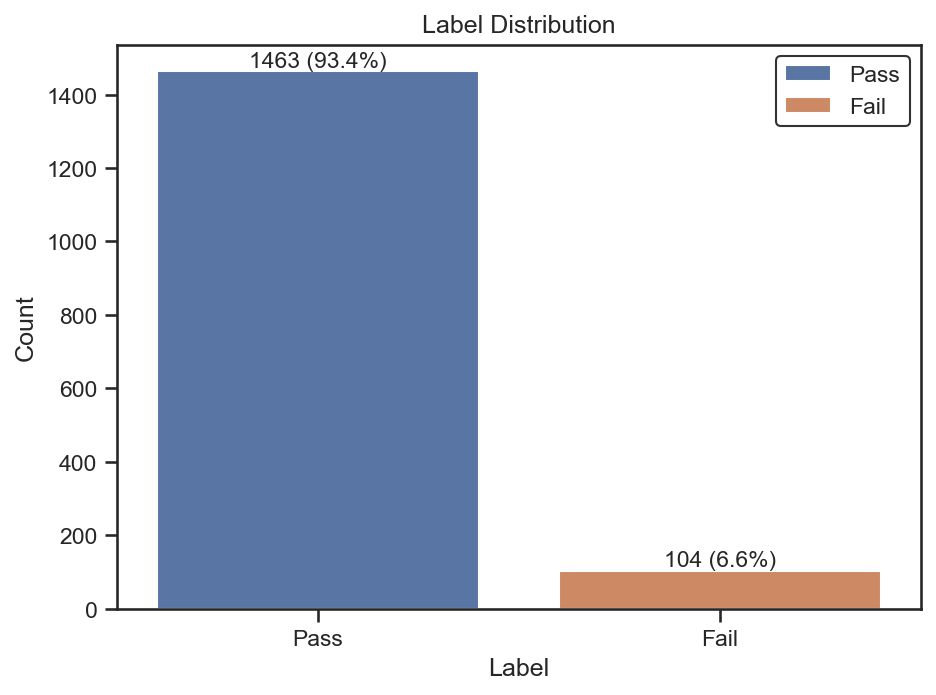

In [20]:
# Countplot
ax = sns.countplot(x="label", data=df, hue="label", legend=True)

ax.set_title("Label Distribution")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels(["Pass", "Fail"])
ax.legend(title=None, labels=['Pass', 'Fail'])
annotate_countplot(ax, summary, position='top')
savefig("01_label_distribution.png")

plt.show()

#### 4.2. Missing value analysis.

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/EDA/02_missingness_distribution.png


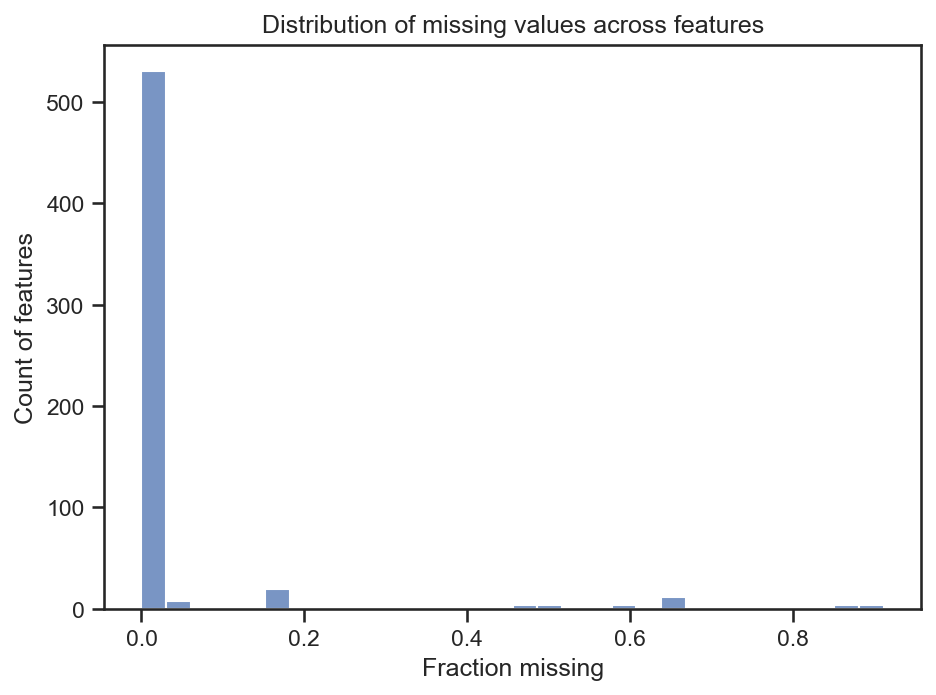

count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64


In [21]:
# Fraction of missing per feature
missing_frac = df.drop(columns=["label", "timestamp"]).isna().mean()

sns.histplot(missing_frac, bins=30)
plt.xlabel("Fraction missing")
plt.ylabel("Count of features")
plt.title("Distribution of missing values across features")
savefig("02_missingness_distribution.png")

plt.show()

print(missing_frac.describe())

### 4.3. Feature distributions (compare Pass vs Fail)

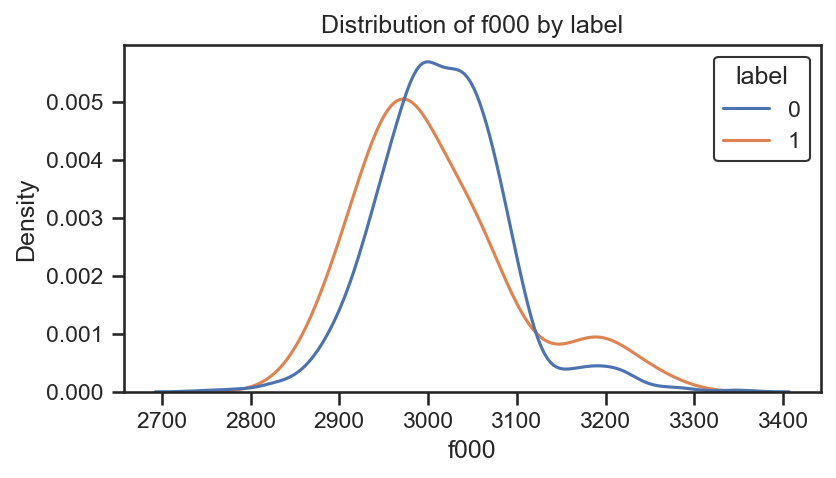

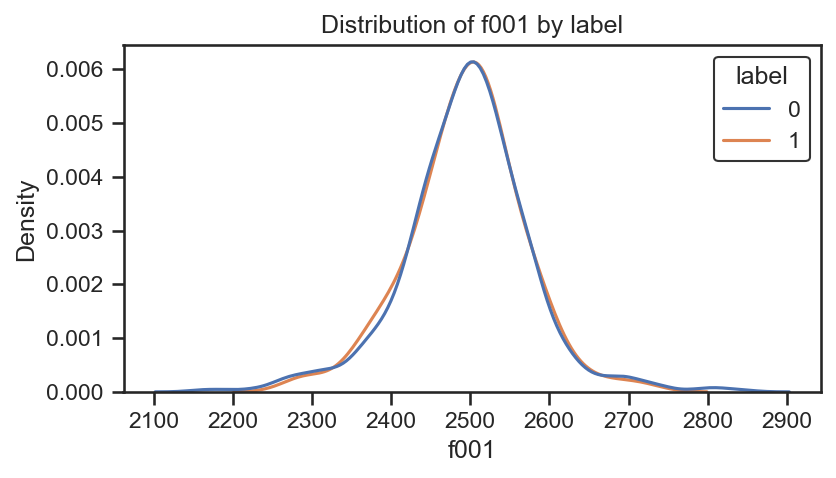

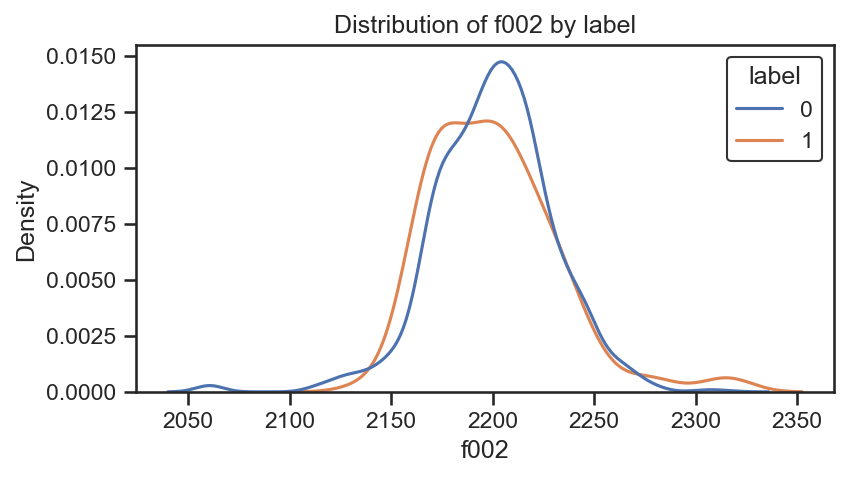

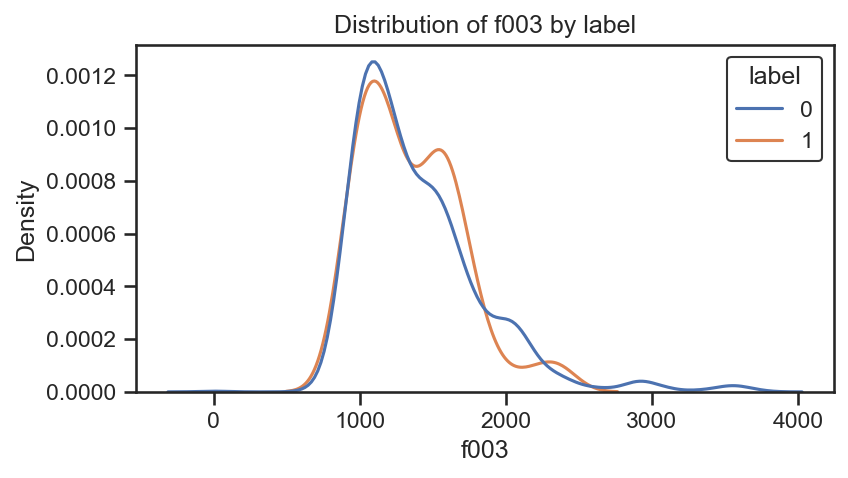

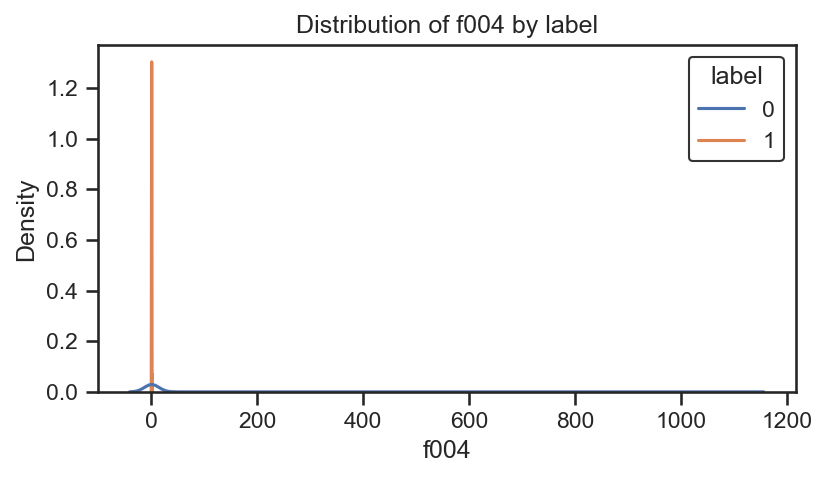

In [22]:
sample_cols = df.columns[:5]  # replace with random.sample(list(df.columns[:-1]), 5)

for col in sample_cols:
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=df, x=col, hue="label", common_norm=False)
    plt.title(f"Distribution of {col} by label")
    plt.show()

### 4.4. Outlier detection per feature (boxplots)

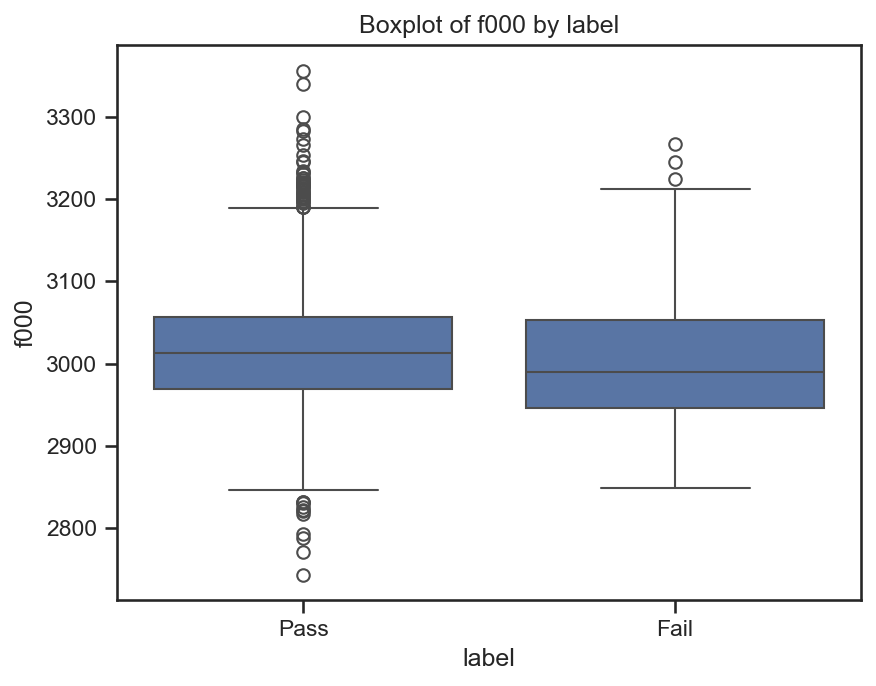

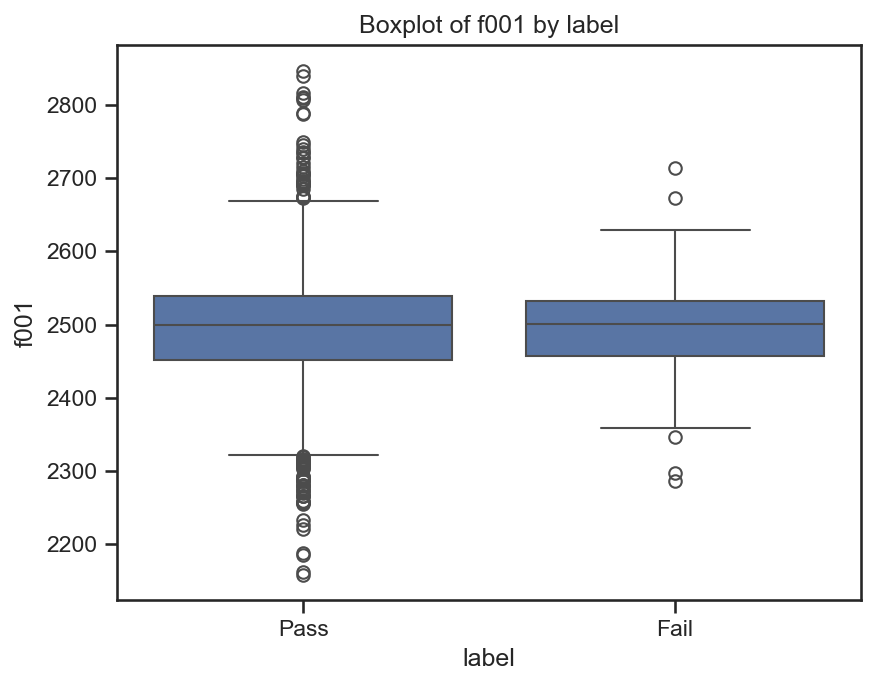

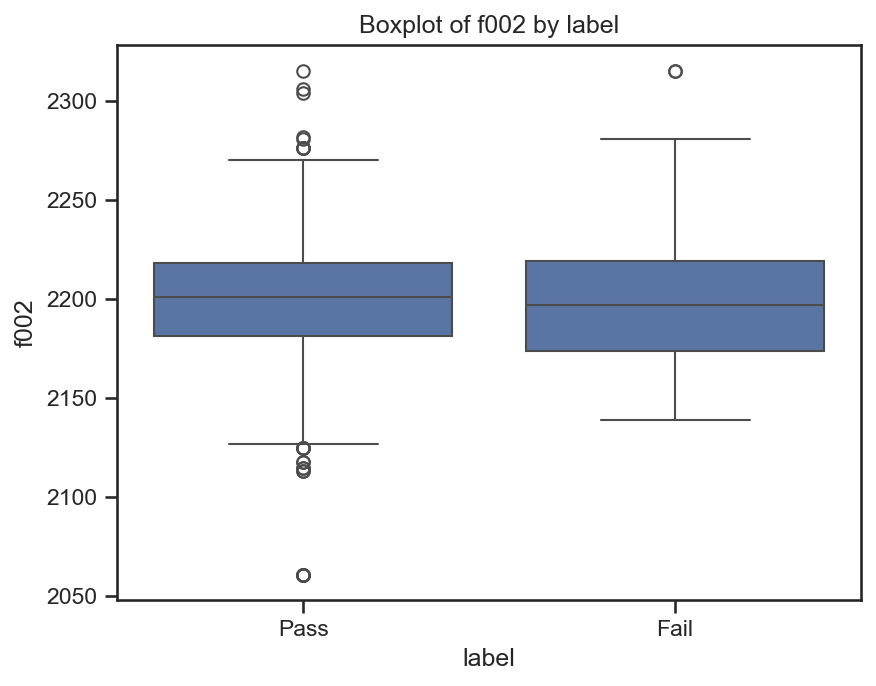

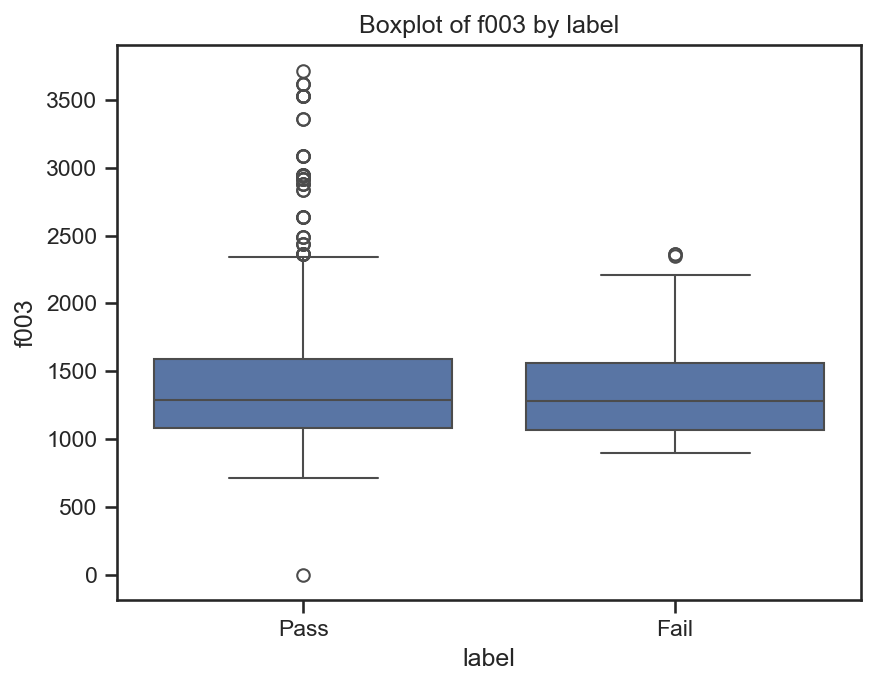

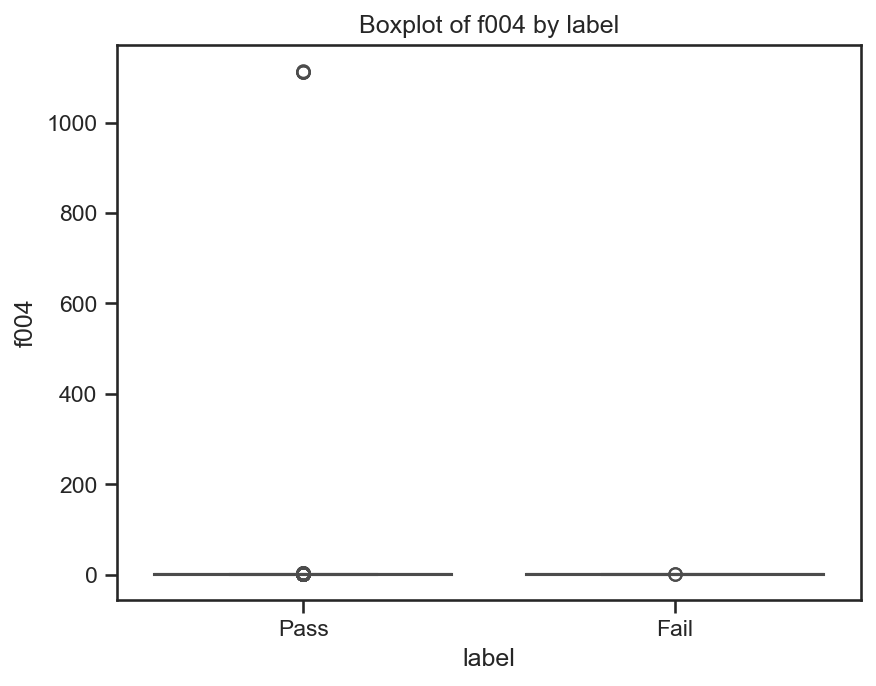

In [23]:
for col in sample_cols:
    ax = sns.boxplot(x="label", y=col, data=df)
    plt.title(f"Boxplot of {col} by label")
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    ax.set_xticklabels(["Pass", "Fail"])
    plt.show()

### 4.5. Correlation structure

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/EDA/04_feature_correlation_heatmap.png


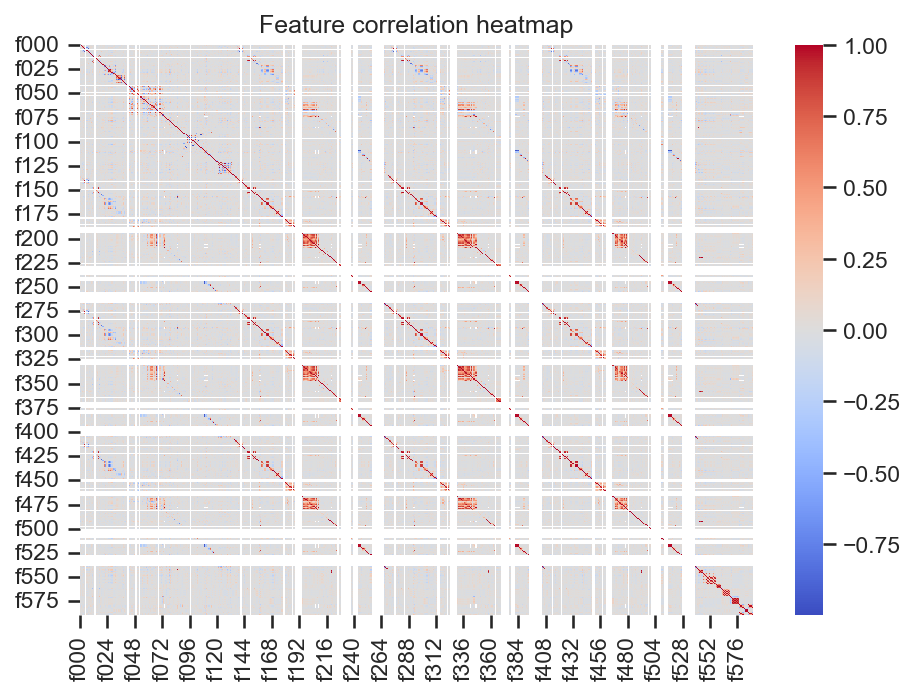

In [24]:
corr = df.drop(columns=["label", "timestamp"]).corr()

#plt.figure(figsize=(10,8))
sns.heatmap(corr.iloc[:,:], cmap="coolwarm", center=0)  # subset 30x30 to avoid clutter
plt.title("Feature correlation heatmap")
savefig("04_feature_correlation_heatmap.png")

plt.show()

### 4.6. Variance by feature

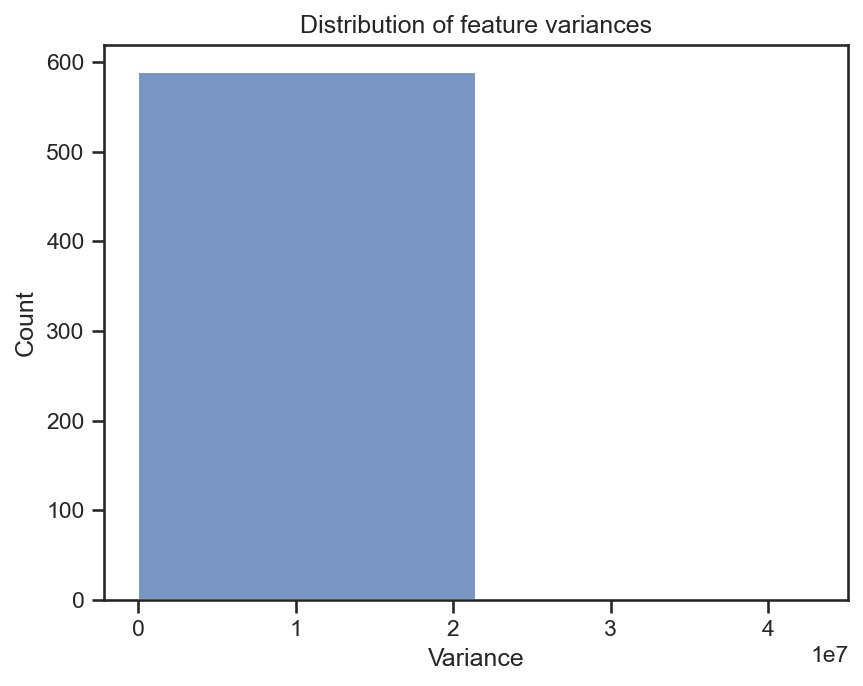

In [25]:
variances = df.drop(columns=["label", "timestamp"]).var()
sns.histplot(variances, bins=2)
plt.xlabel("Variance")
plt.title("Distribution of feature variances")
plt.show()

### 4.7. Dimensionality check (PCA visualization)

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/EDA/03_pca_projection.png


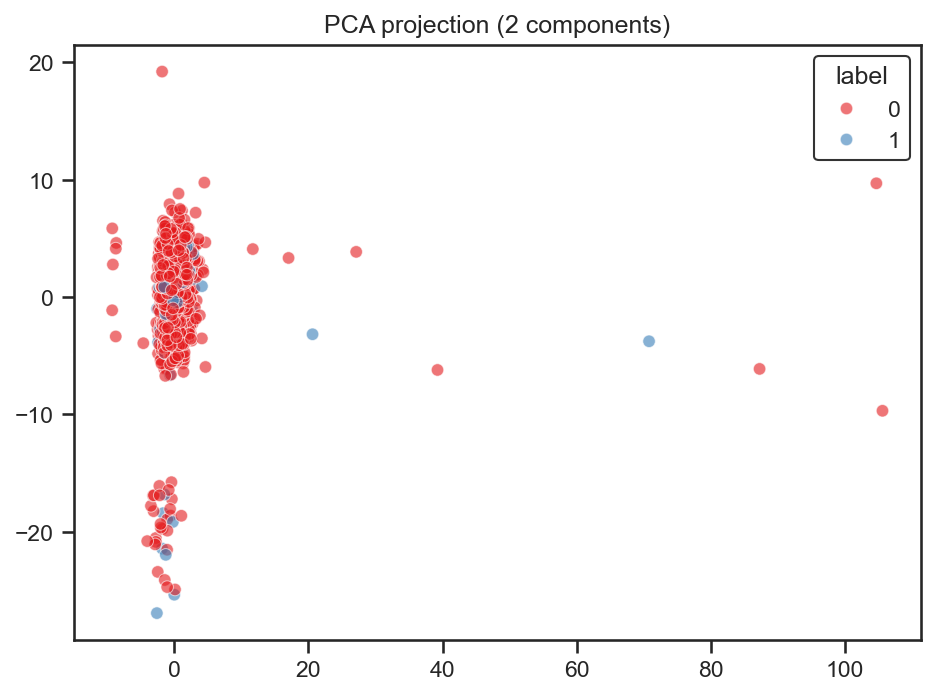

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(df.drop(columns=["label", "timestamp"]).fillna(0))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["label"], alpha=0.6, palette="Set1")
plt.title("PCA projection (2 components)")

savefig("03_pca_projection.png")

plt.show()

In [27]:
df.head()

,f000,f001,f002,f003,f004,f005,f006,f007,f008,f009,...,f582,f583,f584,f585,f586,f587,f588,f589,label,timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,2008-07-19 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,2008-07-19 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,2008-07-19 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,2008-07-19 15:22:00


In [28]:
EDA = Path(DATA_DIR/"interim")
EDA.mkdir(parents=True, exist_ok=True)

df.to_parquet(EDA/"SECOM_EDA.parquet", index=False)